This code was our starting point to implement transfer learning and fine tuning. It is an adaptation of the code seen during the exercise sessions.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# Random seed for reproducibility

n_classes = 14
seed = 22 #Gonzales o Chiesa

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

dataset_dir = '/kaggle/input/dataset-leaves/training'

In [ ]:
!pip install split_folders
import splitfolders

In [ ]:
#We are going back to the 3 folders splitting:
splitfolders.ratio(dataset_dir, output="input/dataset", seed=seed, ratio=(0.70, 0.15, 0.15)) 

Copying files: 17728 files [00:47, 375.95 files/s]


In [ ]:
train_dir = "input/dataset/train"
val_dir = "input/dataset/val"
test_dir = "input/dataset/test"


# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Apply same preprocessing used to train the supernet 
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create an instance of ImageDataGenerator for training, validation, and test sets
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
aug_train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=train_dir,
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=True,
                                               seed=seed)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
val_gen = val_data_gen.flow_from_directory(directory=val_dir,
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)

test_gen = val_data_gen.flow_from_directory(directory=test_dir,
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)


Found 12403 images belonging to 14 classes.
Found 2652 images belonging to 14 classes.
Found 2673 images belonging to 14 classes.


In [ ]:
input_shape = (256, 256, 3)
batch = 32
epochs = 200

2021-11-23 11:26:27.907720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 11:26:28.018152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 11:26:28.018985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 11:26:28.020499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

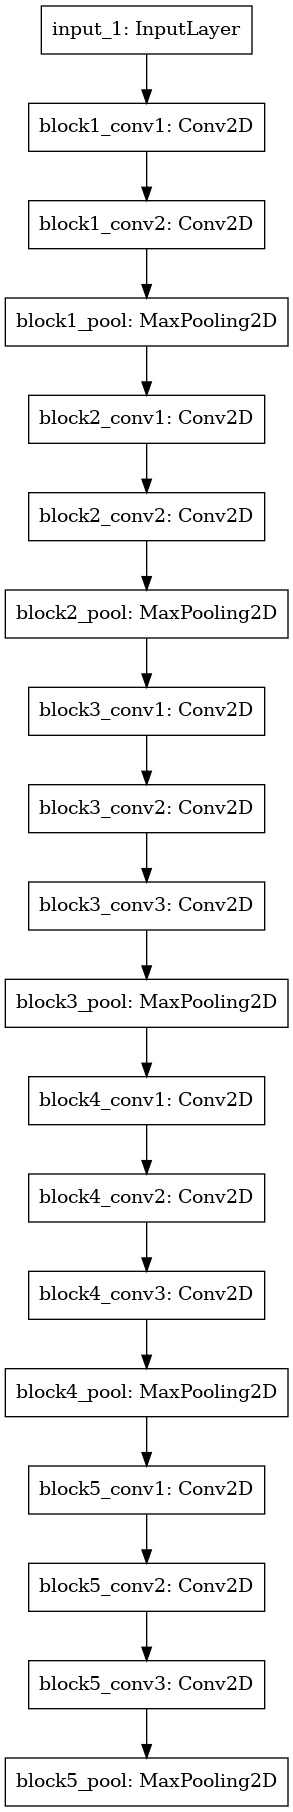

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(input_shape)
x = tfkl.Resizing(256, 256, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('results')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='TransferLearningBase')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    batch_size = batch,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = aug_callbacks
).history

tl_model.save("models/TransferLearningBase")

2021-11-23 11:26:32.769691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-23 11:26:34.396387: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12403/12403 [==============================] - 147s 11ms/step - loss: 2.0985 - accuracy: 0.6703 - val_loss: 0.7453 - val_accuracy: 0.8186
Epoch 2/200
12403/12403 [==============================] - 139s 11ms/step - loss: 1.1569 - accuracy: 0.7493 - val_loss: 1.1107 - val_accuracy: 0.8220
Epoch 3/200
12403/12403 [==============================] - 138s 11ms/step - loss: 1.0838 - accuracy: 0.7765 - val_loss: 0.9131 - val_accuracy: 0.8156
Epoch 4/200
12403/12403 [==============================] - 137s 11ms/step - loss: 1.0817 - accuracy: 0.7963 - val_loss: 0.6180 - val_accuracy: 0.8477
Epoch 5/200
12403/12403 [==============================] - 138s 11ms/step - loss: 1.0264 - accuracy: 0.8121 - val_loss: 0.5793 - val_accuracy: 0.8586
Epoch 6/200
12403/12403 [==============================] - 138s 11ms/step - loss: 0.9917 - accuracy: 0.8321 - val_loss: 0.7420 - val_accuracy: 0.8522
Epoch 7/200
12403/12403 [==============================] - 138s 11ms/step - loss: 0.9178 - accuracy: 0.8289 - va

2021-11-23 12:15:32.393054: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


**Fine tuning:**

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('models/TransferLearningBase')
ft_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 32768)             0        

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = batch,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
12403/12403 [==============================] - 173s 14ms/step - loss: 3.5544 - accuracy: 0.2928 - val_loss: 2.8810 - val_accuracy: 0.3216
Epoch 2/200
12403/12403 [==============================] - 173s 14ms/step - loss: 2.7380 - accuracy: 0.3213 - val_loss: 2.7274 - val_accuracy: 0.3216
Epoch 3/200
12403/12403 [==============================] - 172s 14ms/step - loss: 2.6148 - accuracy: 0.3213 - val_loss: 2.6279 - val_accuracy: 0.3216
Epoch 4/200
12403/12403 [==============================] - 174s 14ms/step - loss: 2.5317 - accuracy: 0.3213 - val_loss: 2.5587 - val_accuracy: 0.3216
Epoch 5/200
12403/12403 [==============================] - 174s 14ms/step - loss: 2.4733 - accuracy: 0.3213 - val_loss: 2.5095 - val_accuracy: 0.3216
Epoch 6/200
12403/12403 [==============================] - 172s 14ms/step - loss: 2.4950 - accuracy: 0.3213 - val_loss: 2.4124 - val_accuracy: 0.3216
Epoch 7/200
12403/12403 [==============================] - 174s 14ms/step - loss: 2.3992 - accuracy:

In [ ]:
ft_model.save('models/FineTuningModel')